In [1]:
import pandas as pd
pd.set_option('display.width', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-bright','classic'])

from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder


/tmp/ipykernel_20629/607241419.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-bright','classic'])


# Fonctions Pour le Perceptron :

In [2]:
import sklearn.model_selection

## full correction, with monitoring, displays, additional exit criterion, etc
def perceptronFullBatch_version_decoree(Xinput, Yinput,eta, w0, maxIter=20, plot=True, verbose=True, Loss="ReLU"):
    
    X, X_valid, Y, Y_valid =\
    sklearn.model_selection.train_test_split(\
        Xinput, Yinput, test_size=0.3, random_state=42)
    N = X.shape[0]
    D = X.shape[1]
    wparameters = w0.copy()  # deep copy
    suiviNbErreurs_ensemble_entrainement    = np.zeros(maxIter)
    suiviNbErreurs_ensemble_validation      = np.zeros(maxIter)
    suiviFonctionCout_ensemble_entrainement = np.zeros(maxIter)
    suiviFonctionCout_ensemble_validation   = np.zeros(maxIter)
    
    err_train, err_val, loss_train, loss_val = suiviNbErreurs_ensemble_entrainement   ,     suiviNbErreurs_ensemble_validation     ,     suiviFonctionCout_ensemble_entrainement,     suiviFonctionCout_ensemble_validation  
    
    ## the algo itself ##
    for iteration in range(maxIter):
        ## we look for misclassified examples ##
        modelValues = X @ wparameters
        XwT = (modelValues)*Y          #  This is   (X @ w * Y)
        misClassified = (XwT <= 0) ## array of booleans (used as a mask or filter)
        misClassifiedNumber = misClassified.sum()  ## True~1, False~0,so by summing up, we count the True's
#         misClassified = ((X@wparameters)*Y)<=0
        if misClassifiedNumber == 0:
            print("Convergence at iteration", iteration)
            if plot :
                display(X,Y, wparameters, iteration)
            print(wparameters)
            return wparameters, err_train, err_val, loss_train, loss_val
        else: ## updating parameters ##

            if Loss=="ReLU":
               #  Rosenblatt style, but full batch:
               wparameters -= -eta/N *\
                (Y[misClassified]@X[misClassified])
            elif Loss=="stupidJ2":
                # following the ~stupid choice J2 of the slides instead
                wparameters -= eta/N * (modelValues - Y) @ X
            else:
                print("You need to choose a Loss function!")
                return wparameters, err_train, err_val, loss_train, loss_val

            if verbose:
                print("iteration #",iteration," there are " , misClassifiedNumber, 'misclassified points => new vector', wparameters)
        if plot :
            display(X,Y, wparameters, iteration)
            
        ## logging of error numbers and cost function value over epochs (GD iterations)
        ## filtres booleens
        misClassified_train=  ((X       @ wparameters)*Y        <= 0)
        misClassified_valid = ((X_valid @ wparameters)*Y_valid  <= 0)
        ## nombre erreurs
        suiviNbErreurs_ensemble_entrainement    [iteration] = misClassified_train.mean() ## == misClassifiedNumber
        suiviNbErreurs_ensemble_validation      [iteration] = misClassified_valid.mean()
        ## valuer fonciton cout
        suiviFonctionCout_ensemble_entrainement [iteration] = np.mean( -X      [misClassified_train]@ wparameters * Y      [misClassified_train])
        suiviFonctionCout_ensemble_validation   [iteration] = np.mean( -X_valid[misClassified_valid]@ wparameters * Y_valid[misClassified_valid])


    print("No convergence after", maxIter, "iterations.\nThere were misClassifiedNumber*100/N=",misClassifiedNumber/N*100, "% misclassified data points.")
    err_train, err_val, loss_train, loss_val = suiviNbErreurs_ensemble_entrainement   ,     suiviNbErreurs_ensemble_validation     ,     suiviFonctionCout_ensemble_entrainement,     suiviFonctionCout_ensemble_validation  
    return wparameters, err_train, err_val, loss_train, loss_val




In [3]:
## Il peut etre utile de definir la norme d'un vecteur:
def norme(w):
    return ((w**2).sum())**0.5

def display(X, Y, wInit, iteration):
    w=wInit.copy()
    w0= w[0] # c'est la partie qui caractérise la distance à l'origine, qui détermine l'ordonnée à l'origine (mais ce n'est pas égal à ça)
    ## on normalise les composantes du vrai vecteur w
    wprime = w[1:] # /(w[1]**2+w[2]**2)**0.5
    print(w, w0, wprime)

    u_w = (wprime/norme(wprime)) # vecteur unitaire donnant la direction
    distance_origine_droite = -w0/norme(wprime)
    projete_de_Origine_sur_droite = u_w * distance_origine_droite
    print("projete_de_Origine_sur_droite", projete_de_Origine_sur_droite)

    vecteur_Orthogonal_A_La_Droite = np.array([wprime[1],-wprime[0]])
    extremite1 = projete_de_Origine_sur_droite + vecteur_Orthogonal_A_La_Droite*10
    extremite2 = projete_de_Origine_sur_droite - vecteur_Orthogonal_A_La_Droite*10
    extremites_abscisses = np.array([extremite1[0], extremite2[0]])
    extremites_ordonnees = np.array([extremite1[1], extremite2[1]])

    plt.figure(1)
    Class1 = X[Y==-1,1:] # points of class "-1"
    Class2 = X[Y== 1,1:] # points of class "+1"
    plt.plot(Class1[:,0], Class1[:,1], 'r+') # points of class "-1"
    plt.plot(Class2[:,0], Class2[:,1], 'bx') # points of class "+1"
    cmap = cm.jet
    colorGradient=cmap(np.linspace(0.0,1.0,12))
    plt.plot(extremites_abscisses, extremites_ordonnees,  color=colorGradient[iteration%(len(colorGradient))])
    print(extremites_abscisses)


def initializeWeights(X, type):
    ## data dimension
    D = X.shape[1]

    ## choice 1: deterministic
    if type=="zero":
        wparameters = np.zeros((D))
        wparameters[0] = 0.00001

    ## choice 2: uniform random centered in 0
    ##           with appropriate order of magnitude
    elif type=="random":
        wparameters = (np.random.random((D))-0.5)/D**0.5

    return wparameters

## minimalistic correction:
def perceptronFullBatch_version_minimale(X,Y,eta, w0, maxIter=20, plot=None, verbose=None, Loss=None):
    N = X.shape[0]
    D = X.shape[1]
    wparameters = w0.copy()  # deep copy
    for iteration in range(maxIter):
        misClassified = ((X @ wparameters)*Y  <= 0) ## array of booleans (used as a mask or filter)
        wparameters -= -eta/N * (Y[misClassified]@X[misClassified])
    return wparameters


## Exploration des données

### Aperçu des données

In [4]:
data = pd.read_csv('players_stats.csv')
data.head(15)

,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
0,AJ Price,26,324,133,51,137,37.2,15,57,26.3,...,29.0,us,"October 7, 1986",University of Connecticut,5,185.0,PG,PHO,81.45,23.798393
1,Aaron Brooks,82,1885,954,344,817,42.1,121,313,38.7,...,30.0,us,"January 14, 1985",University of Oregon,6,180.0,PG,CHI,72.45,22.361111
2,Aaron Gordon,47,797,243,93,208,44.7,13,48,27.1,...,20.0,us,"September 16, 1995",University of Arizona,R,202.5,PF,ORL,99.00,24.142661
3,Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,...,24.0,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.377751
4,Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,...,29.0,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.234384
5,Al Jefferson,65,1992,1082,486,1010,48.1,2,5,40.0,...,30.0,us,"January 4, 1985",NaN,10,205.0,C,CHA,130.05,30.945866
6,Alan Anderson,74,1744,545,195,440,44.3,73,210,34.8,...,33.0,us,"October 16, 1982",Michigan State University,5,195.0,SG,NJN,99.00,26.035503
7,Alec Burks,27,899,374,121,300,40.3,26,68,38.2,...,24.0,us,"July 20, 1991",University of Colorado,3,195.0,SG,UTA,96.30,25.325444
8,Alex Kirk,5,14,4,1,4,25.0,0,0,0.0,...,24.0,us,"November 14, 1991",University of New Mexico,R,210.0,C,CLE,110.25,25.000000
9,Alex Len,69,1518,432,179,353,50.7,1,3,33.3,...,22.0,ua,"June 16, 1993",University of Maryland,1,212.5,C,PHO,117.00,25.910035


#### On retire les valeurs manquantes

In [5]:
data = data.dropna()
data

,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
0,AJ Price,26,324,133,51,137,37.2,15,57,26.3,...,29.0,us,"October 7, 1986",University of Connecticut,5,185.0,PG,PHO,81.45,23.798393
1,Aaron Brooks,82,1885,954,344,817,42.1,121,313,38.7,...,30.0,us,"January 14, 1985",University of Oregon,6,180.0,PG,CHI,72.45,22.361111
2,Aaron Gordon,47,797,243,93,208,44.7,13,48,27.1,...,20.0,us,"September 16, 1995",University of Arizona,R,202.5,PF,ORL,99.00,24.142661
3,Adreian Payne,32,740,213,91,220,41.4,1,9,11.1,...,24.0,us,"February 19, 1991",Michigan State University,R,205.0,PF,ATL,106.65,25.377751
4,Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,...,29.0,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.234384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,Willie Green,52,951,306,118,306,38.6,42,121,34.7,...,34.0,us,"July 28, 1981",University of Detroit Mercy,11,190.0,SG,ORL,90.00,24.930748
484,Wilson Chandler,78,2471,1085,418,975,42.9,139,406,34.2,...,28.0,us,"May 10, 1987",DePaul University,7,200.0,SF,DEN,101.25,25.312500
485,Xavier Henry,9,86,20,3,13,23.1,0,0,0.0,...,24.0,be,"March 15, 1991",University of Kansas,4,195.0,SF,LAL,99.00,26.035503
486,Zach LaVine,77,1902,778,286,677,42.2,57,167,34.1,...,20.0,us,"March 10, 1995","University of California, Los Angeles",R,192.5,PG,MIN,85.05,22.951594


#### On sépare les joueurs en deux catégories d'après leurs positions (Extérieur/Intérieur) Ici en seulement deux classes différentes

In [6]:
data["PosBin"] = data["Pos"].apply(lambda x: 1 if x in ["PG","SG"] else 0)
data = data.drop(['Name','Birth_Place','Birthdate','Collage','Experience','Team','Pos'], axis=1)
X = data.drop('PosBin', axis=1)
y = data['PosBin']
sc = StandardScaler()
X = sc.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

R2 :  0.7056349873843566
MSE :  0.07142857142857142


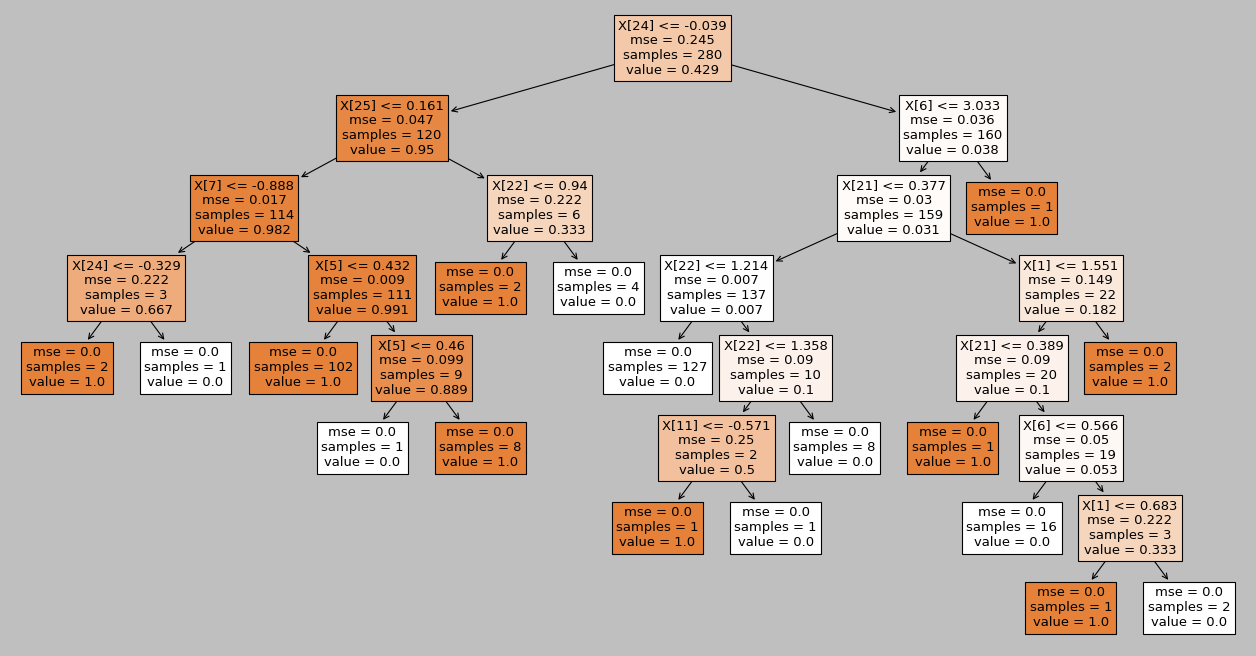

In [8]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("R2 : ", r2_score(y_test, y_pred))
print("MSE : ", mean_squared_error(y_test, y_pred))
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True)
plt.show()

In [9]:
features = list(data.columns[1:])
features

['MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG%',
 '3PM',
 '3PA',
 '3P%',
 'FTM',
 'FTA',
 'FT%',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'EFF',
 'AST/TOV',
 'STL/TOV',
 'Age',
 'Height',
 'Weight',
 'BMI',
 'PosBin']

/tmp/ipykernel_20629/1402125547.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-bright','dark_background'])
/tmp/ipykernel_20629/1402125547.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-bright','dark_background'])
/tmp/ipykernel_20629/1402125547.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alt

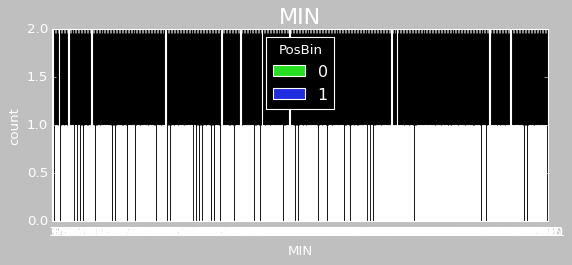

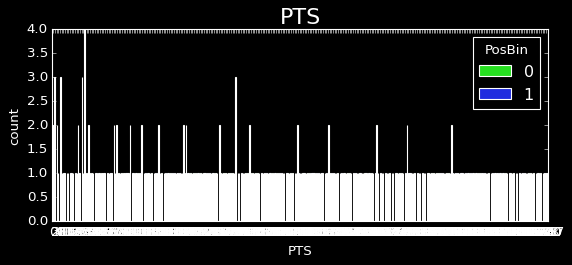

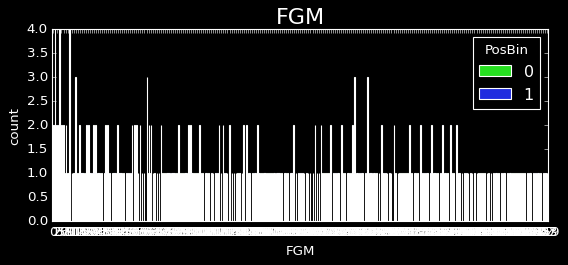

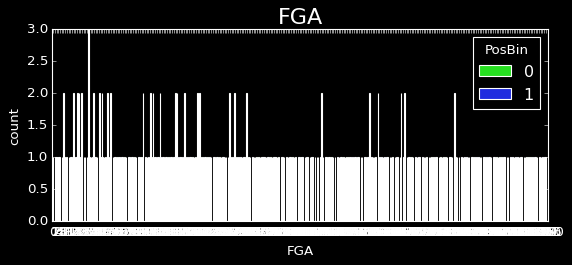

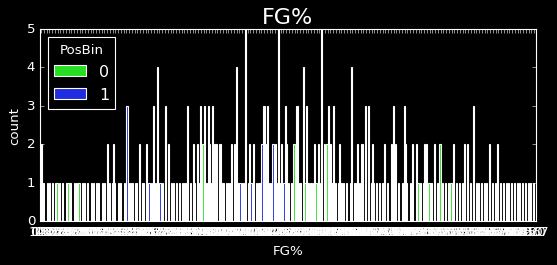

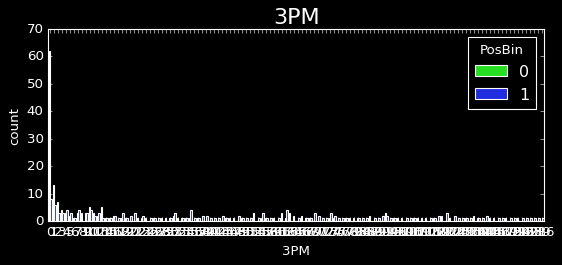

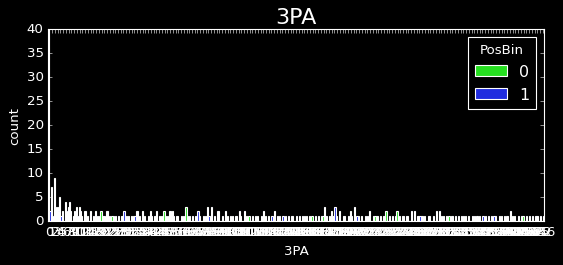

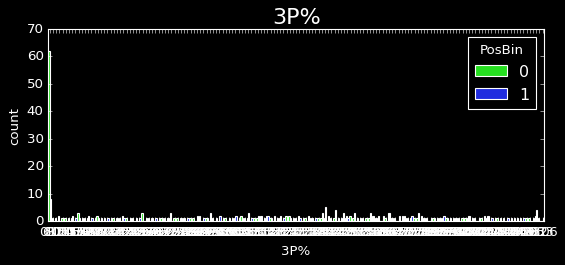

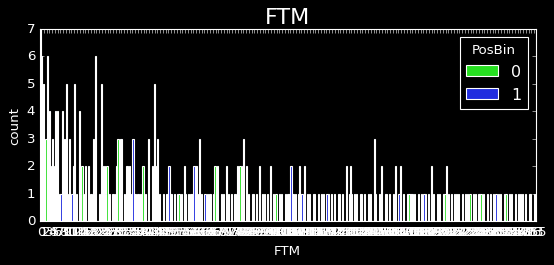

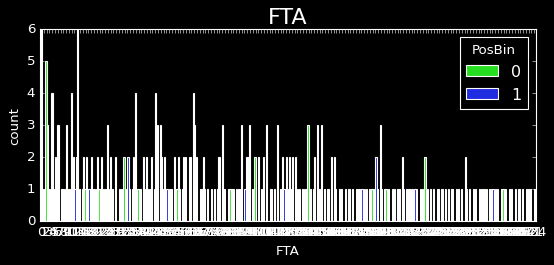

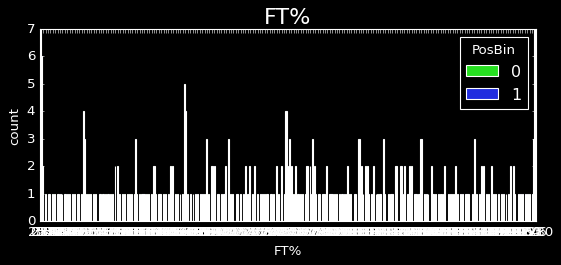

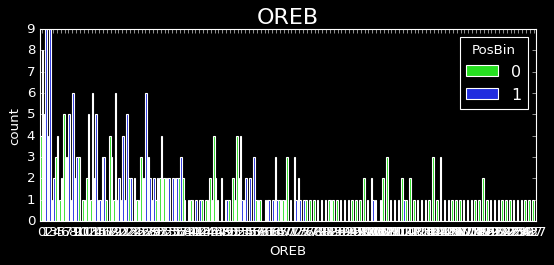

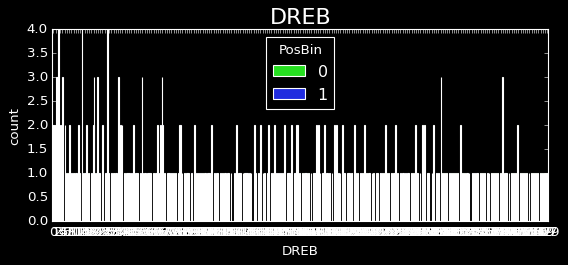

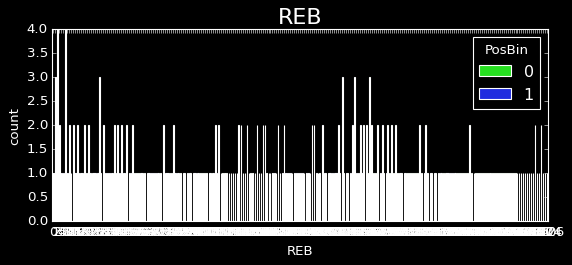

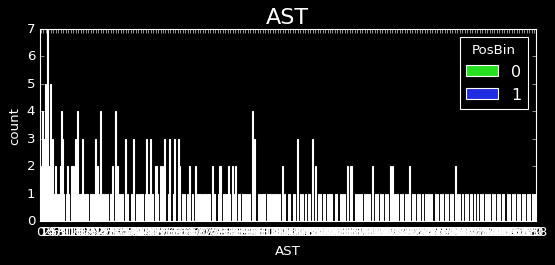

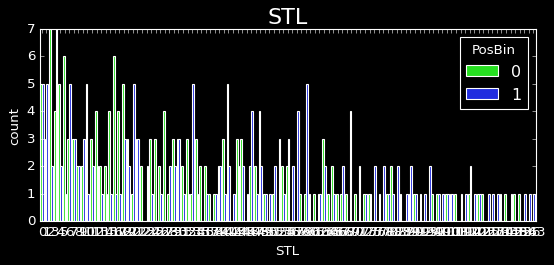

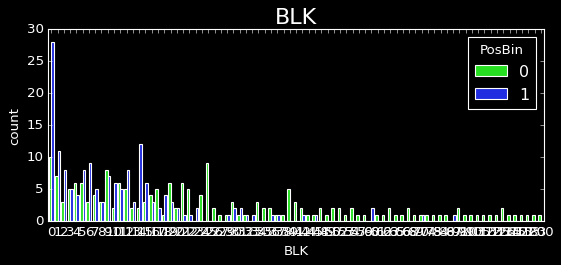

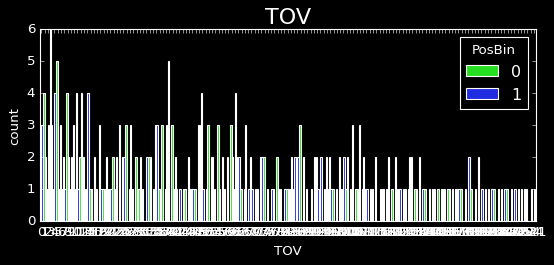

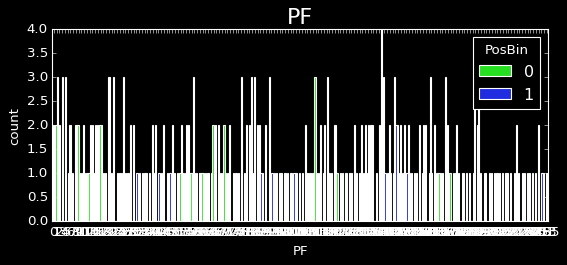

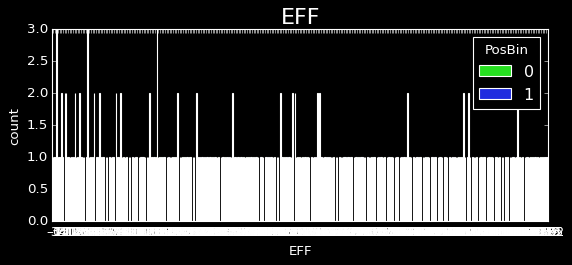

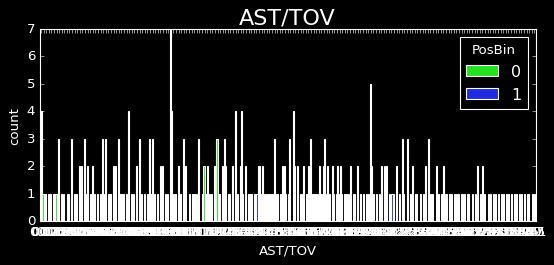

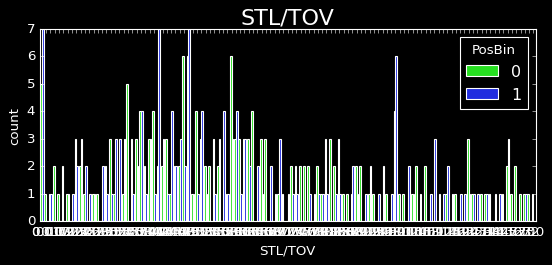

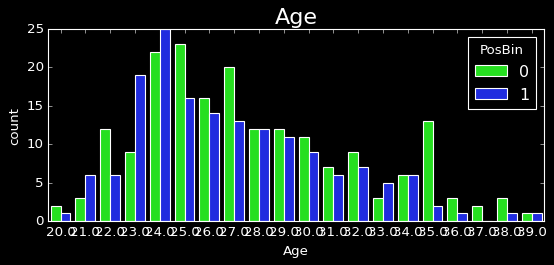

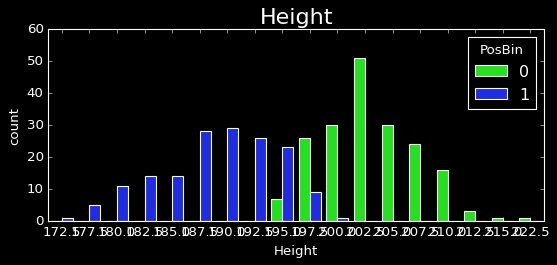

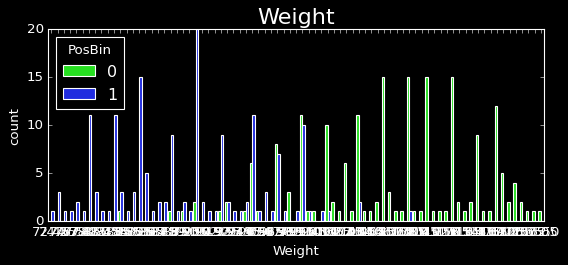

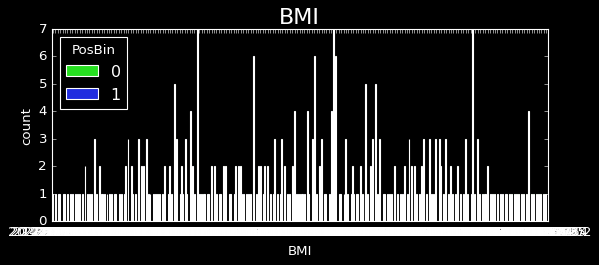

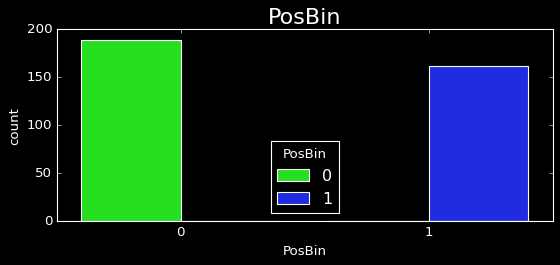

In [10]:
for i in features:
    plt.figure(figsize=(8,3))
    plt.style.use(['seaborn-bright','dark_background'])
    sns.countplot(x = data[i],data = data, hue = 'PosBin', palette='hsv')
    plt.title(i,fontsize=20,color='w')

In [11]:
from sklearn.model_selection import train_test_split
x_onehot = OneHotEncoder().fit_transform(X)
x_onehot.shape  #la shape obtenue est un peu étonnante

## on prend 80% pour le train+validation set, 20% pour le test (tout a la fin !)
x_train, x_test, y_train, y_test = train_test_split(x_onehot.toarray(), y, test_size=0.2, random_state = 101)

## on prend 20% du 80% pour le validation set
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state = 101)

No convergence after 200 iterations.
There were misClassifiedNumber*100/N= 70.20408163265306 % misclassified data points.


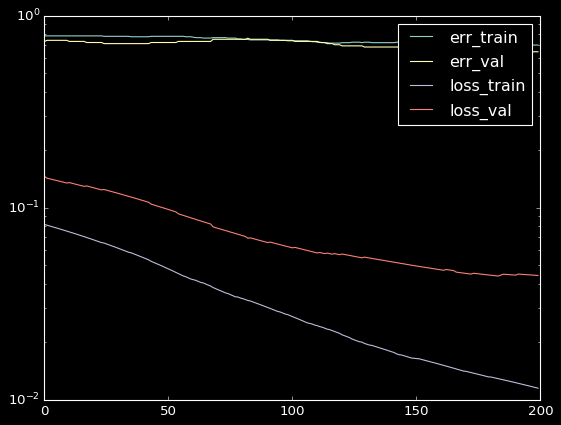

In [12]:
### hyper-parameters ###
MAXITER=200
eta = 0.001

## on lance le calcul
plotting=False
verbose=False

## on initialise w avec la bonne dimension (ceci pourrait/devrait etre fait dans la fonction de fit, en fait)
np.random.seed(1)
w0 = initializeWeights(X, "random")

w, err_train, err_val, loss_train, loss_val =  perceptronFullBatch_version_decoree(X,y,eta, w0, MAXITER, plotting, verbose)

plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')
plt.plot(loss_train, label = 'loss_train')
plt.plot(loss_val, label = 'loss_val')
plt.semilogy()
plt.legend()

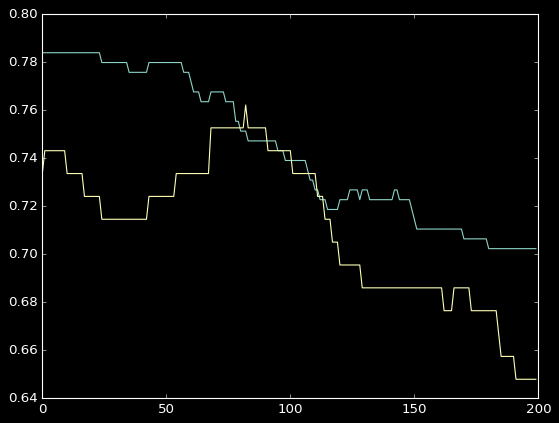

In [13]:
plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')

# #2 On sépare les joueurs en plusieurs catégories d'après leurs positions (Extérieur/Intérieur) Ici en 5 classes différentes correspondantes aux positions sur le terrain

In [14]:
data = pd.read_csv('players_stats.csv')
data = data.dropna()

In [15]:
data["PosBin"] = data["Pos"].apply(lambda x: 1 if x in ["PG"] else 2 if x in ["SG"] else 3 if x in ["SF"] else 4 if x in ["PF"] else 5)

#### On supprime les colonnes inutiles

In [16]:
data = data.drop(['Name','Birth_Place','Birthdate','Collage','Experience','Team','Pos'], axis=1)

In [17]:
data.columns

Index(['Games Played', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'Age', 'Height', 'Weight', 'BMI',
       'PosBin'],
      dtype='object')

In [18]:
X = data.drop('PosBin', axis=1)
y = data['PosBin']

In [19]:
subset = ['Games Played', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%',
       'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'EFF', 'AST/TOV', 'STL/TOV', 'Age', 'Height', 'Weight', 'BMI',
       'PosBin']
print(data[subset].head(5).to_latex())

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  Games Played &   MIN &   PTS &  FGM &  FGA &   FG\% &  3PM &  3PA &   3P\% &  FTM &  FTA &   FT\% &  OREB &  DREB &  REB &  AST &  STL &  BLK &  TOV &   PF &   EFF &  AST/TOV &  STL/TOV &   Age &  Height &  Weight &        BMI &  PosBin \\
\midrule
0 &            26 &   324 &   133 &   51 &  137 &  37.2 &   15 &   57 &  26.3 &   16 &   24 &  66.7 &     6 &    26 &   32 &   46 &    7 &    0 &   14 &   15 &   110 &     3.29 &     0.50 &  29.0 &   185.0 &   81.45 &  23.798393 &       1 \\
1 &            82 &  1885 &   954 &  344 &  817 &  42.1 &  121 &  313 &  38.7 &  145 &  174 &  83.3 &    32 &   134 &  166 &  261 &   54 &   15 &  157 &  189 &   791 &     1.66 &     0.34 &  30.0 &   180.0 &   72.45 &  22.361111 &       1 \\
2 &            47 &   797 &   243 &   93 &  208 &  44.7 &   13 &   48 &  27.1 &   44 &   61 &  72.1 &    46 &   123 &  169 &   33 &   21 &   22 &   38 &   83 &   318 &     0.87 &     0.55 &  20.0 &   202.5

/tmp/ipykernel_20629/468572285.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data[subset].head(5).to_latex())


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 350 entries, 0 to 487
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Games Played  350 non-null    int64  
 1   MIN           350 non-null    int64  
 2   PTS           350 non-null    int64  
 3   FGM           350 non-null    int64  
 4   FGA           350 non-null    int64  
 5   FG%           350 non-null    float64
 6   3PM           350 non-null    int64  
 7   3PA           350 non-null    int64  
 8   3P%           350 non-null    float64
 9   FTM           350 non-null    int64  
 10  FTA           350 non-null    int64  
 11  FT%           350 non-null    float64
 12  OREB          350 non-null    int64  
 13  DREB          350 non-null    int64  
 14  REB           350 non-null    int64  
 15  AST           350 non-null    int64  
 16  STL           350 non-null    int64  
 17  BLK           350 non-null    int64  
 18  TOV           350 non-null    

#### On vérifie qu'il n'y ait pas de valeurs nulles

In [21]:
data.isnull().sum() 

Games Played    0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3PM             0
3PA             0
3P%             0
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
PF              0
EFF             0
AST/TOV         0
STL/TOV         0
Age             0
Height          0
Weight          0
BMI             0
PosBin          0
dtype: int64

In [22]:
data.describe(include = 'all')

,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,...,TOV,PF,EFF,AST/TOV,STL/TOV,Age,Height,Weight,BMI,PosBin
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,...,350.000000,350.000000,350.00000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,52.517143,1207.868571,495.825714,185.117143,416.214286,42.562857,41.548571,117.894286,26.019429,84.042857,...,67.108571,99.580000,553.06000,1.522343,0.650800,27.320000,196.585714,98.821286,25.480802,2.817143
std,24.227160,835.251245,428.888777,157.370533,341.570395,9.008060,50.338643,131.781067,14.944837,91.581963,...,58.295706,65.125562,468.69517,0.831199,0.382874,4.138768,8.626262,12.284187,1.686314,1.367131
min,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-3.00000,0.000000,0.000000,20.000000,172.500000,72.450000,20.411523,1.000000
25%,33.000000,418.500000,135.250000,51.250000,124.000000,39.500000,1.000000,7.250000,17.975000,16.250000,...,20.250000,42.250000,155.00000,0.960000,0.410000,24.000000,190.000000,90.000000,24.305556,2.000000
50%,60.000000,1192.000000,397.500000,149.000000,349.000000,42.700000,19.000000,61.000000,31.400000,54.500000,...,52.000000,100.500000,472.00000,1.440000,0.570000,27.000000,197.500000,99.000000,25.532110,3.000000
75%,73.000000,1905.750000,779.000000,290.250000,655.500000,46.700000,67.750000,193.000000,36.175000,122.750000,...,99.000000,147.000000,827.75000,2.000000,0.845000,30.000000,202.500000,108.000000,26.530612,4.000000
max,82.000000,2981.000000,2217.000000,659.000000,1470.000000,85.700000,286.000000,646.000000,63.600000,715.000000,...,321.000000,285.000000,2202.00000,6.500000,3.000000,39.000000,222.500000,162.000000,32.723141,5.000000


In [23]:
sc = StandardScaler()
X = sc.fit_transform(X)
le = LabelEncoder()
y = le.fit_transform(y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

In [26]:
print("R2 : ", r2_score(y_test, y_pred))
print("MSE : ", mean_squared_error(y_test, y_pred))

R2 :  0.7128573259838482
MSE :  0.45714285714285713


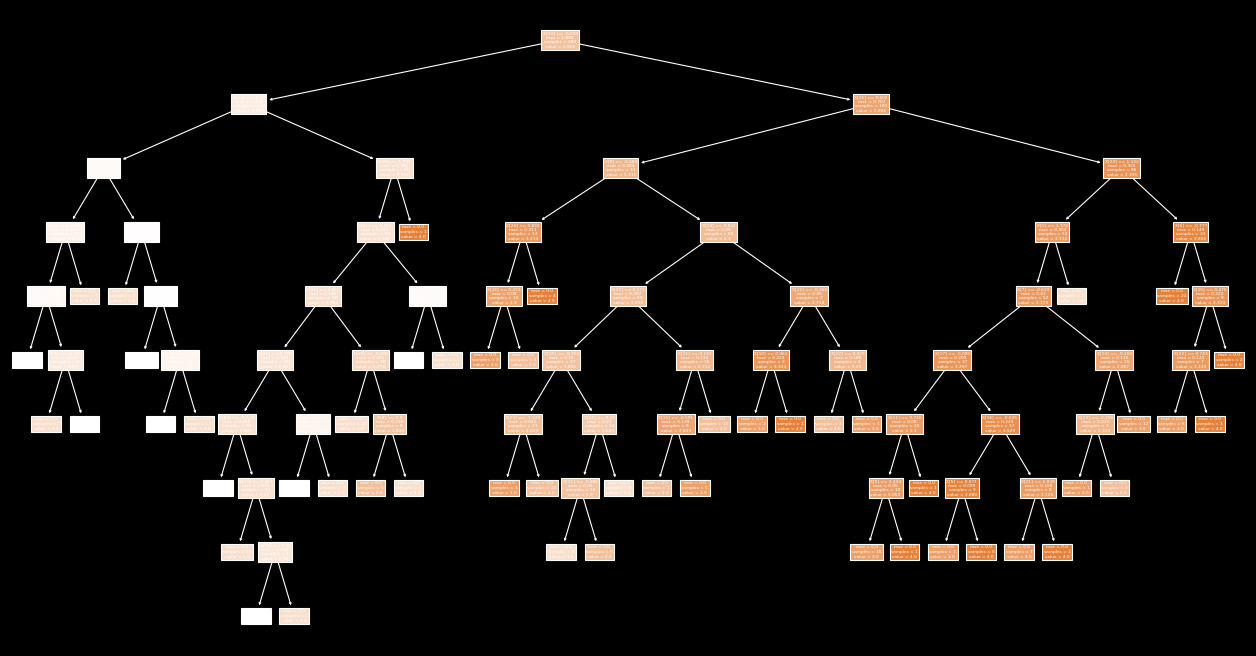

In [27]:
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True)
plt.show()

### Visualisation de la fréquence d'apparition (d'une valeur) d'attribut (par Pos)

In [28]:
features

['MIN',
 'PTS',
 'FGM',
 'FGA',
 'FG%',
 '3PM',
 '3PA',
 '3P%',
 'FTM',
 'FTA',
 'FT%',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'EFF',
 'AST/TOV',
 'STL/TOV',
 'Age',
 'Height',
 'Weight',
 'BMI',
 'PosBin']

# Les positions des joueurs en fonctions de leur Height et Weight

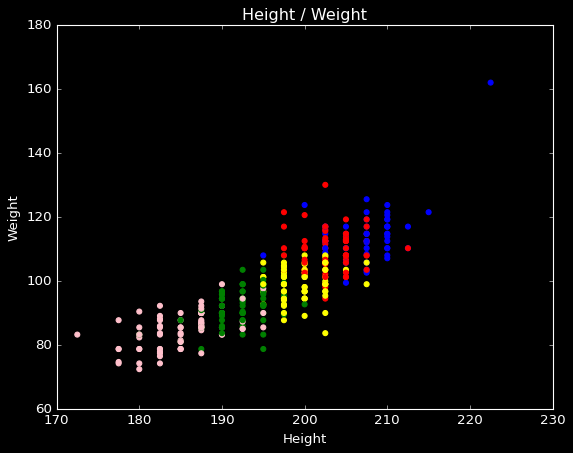

In [62]:
values = ['Pink','Green','Yellow','Red','Blue']
x = data['Height']
y = data['Weight']

z = []
for i in data['PosBin']:
    z.append(i) 
    
plt.scatter(x, y, color=[values[int(i-1)] for i in z])

plt.title('Height / Weight')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.show()

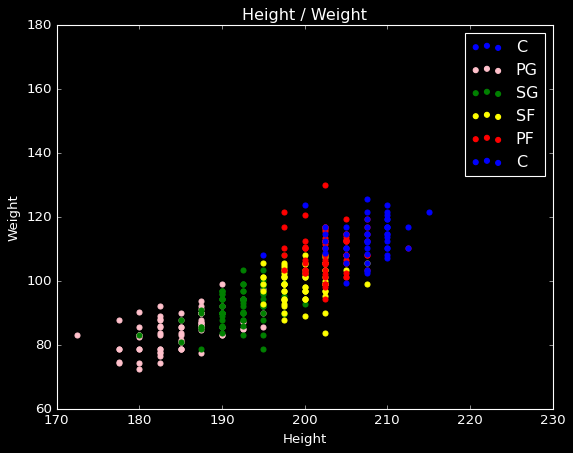

In [70]:
values = ['Pink','Green','Yellow','Red','Blue']
x = data['Height']
y = data['Weight']
z = data['PosBin']

legend_dict = {'Pink': 'PG', 'Green': 'SG', 'Yellow': 'SF', 'Red': 'PF', 'Blue': 'C'}

for i in range(len(values)+1):
    plt.scatter(x[z==i], y[z==i], color=values[i-1], label=legend_dict[values[i-1]])

plt.title('Height / Weight')
plt.xlabel('Height')
plt.ylabel('Weight')
plt.legend()
plt.show()

/tmp/ipykernel_14885/1402125547.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-bright','dark_background'])
/tmp/ipykernel_14885/1402125547.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-bright','dark_background'])
/tmp/ipykernel_14885/1402125547.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alt

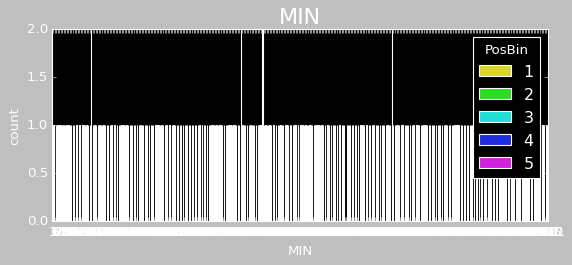

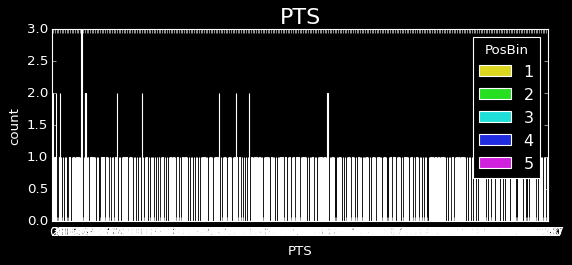

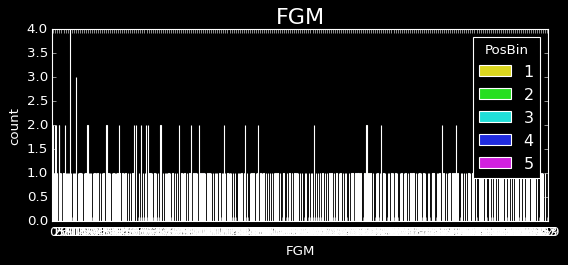

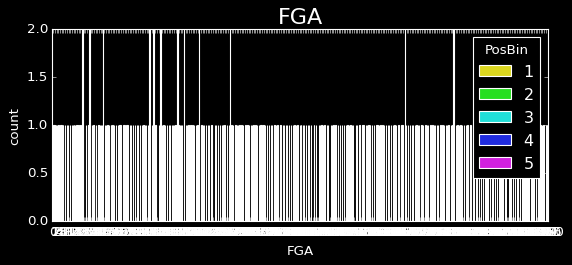

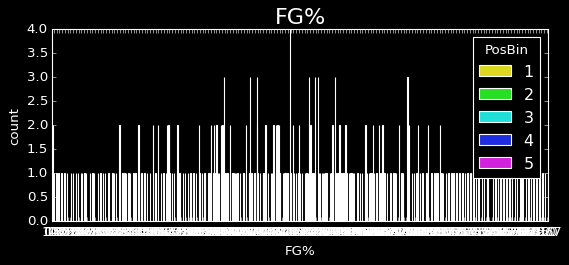

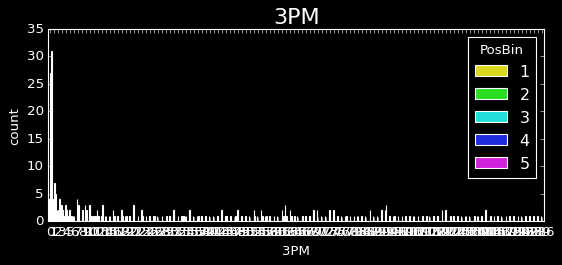

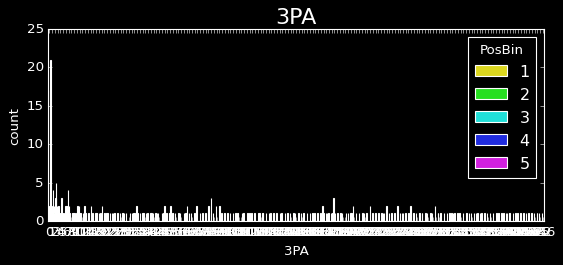

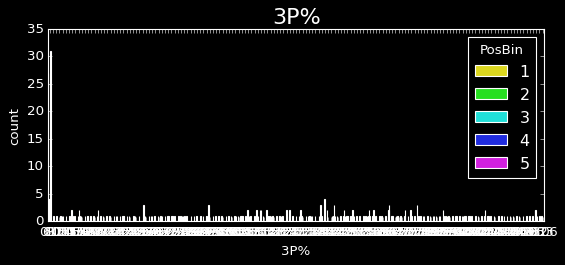

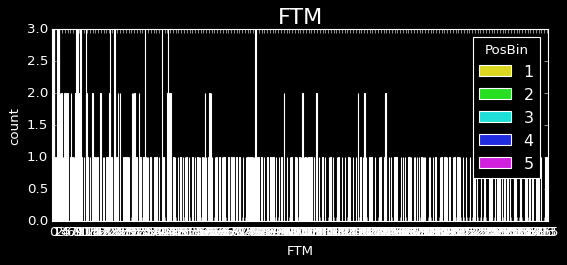

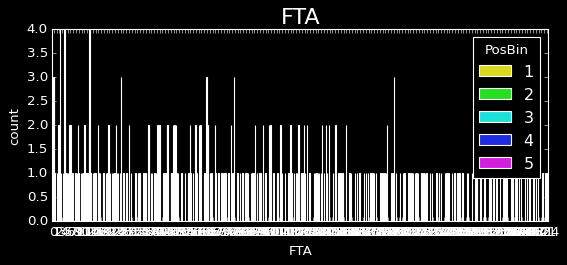

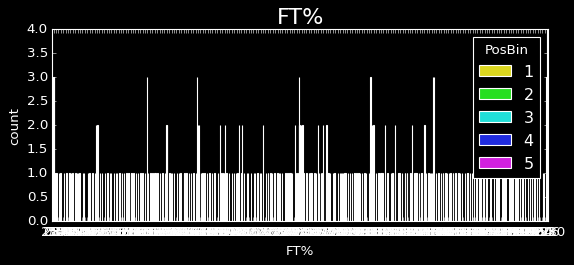

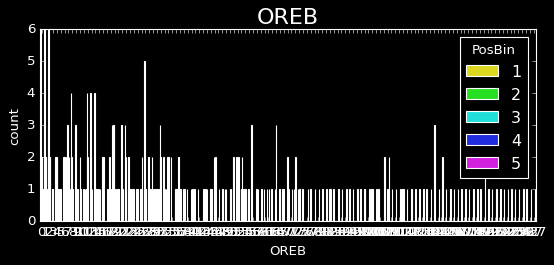

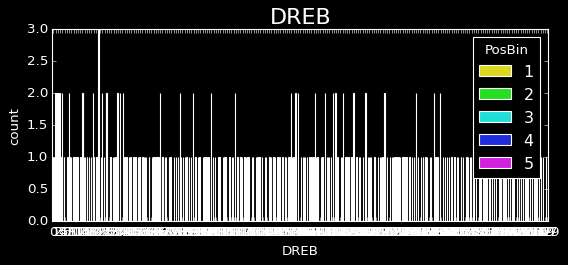

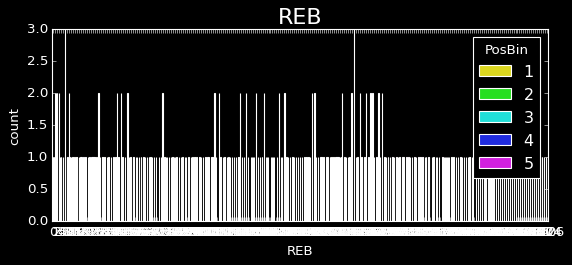

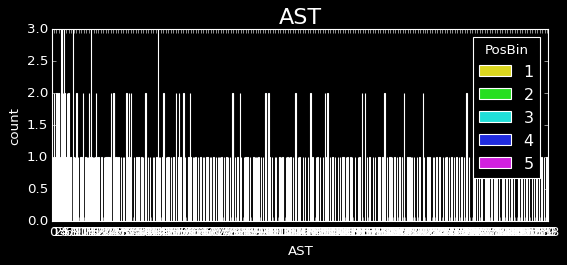

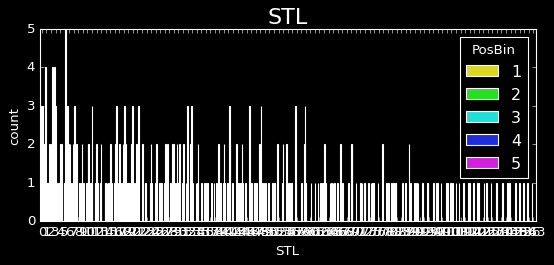

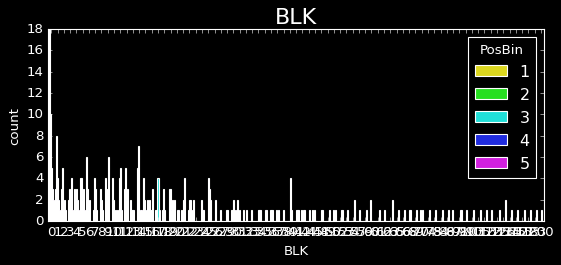

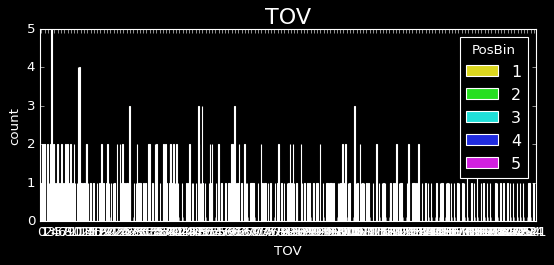

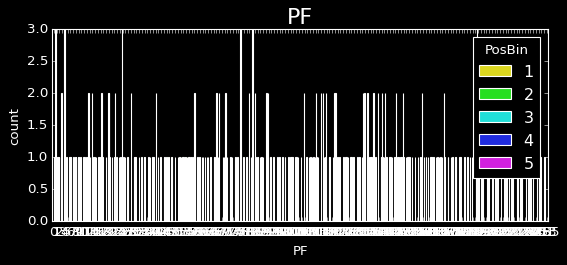

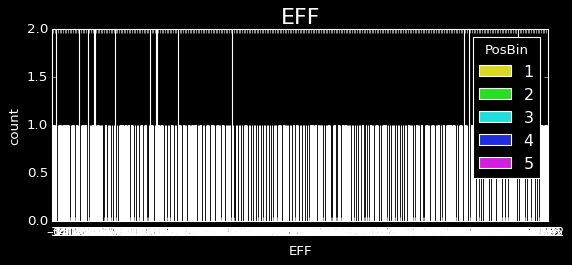

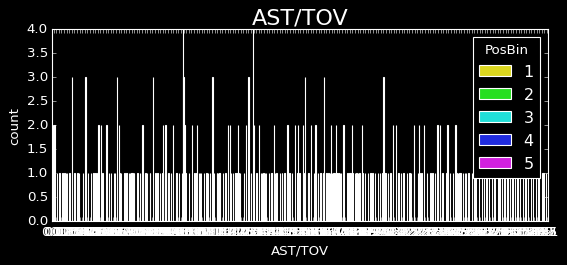

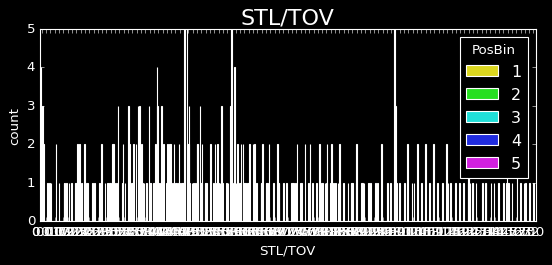

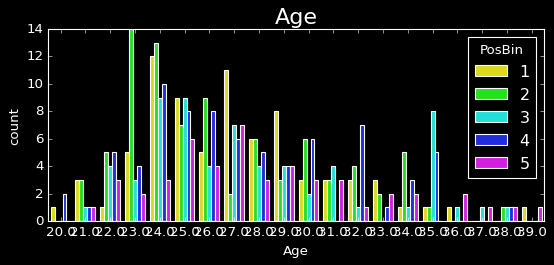

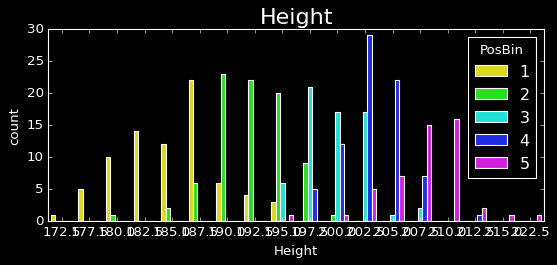

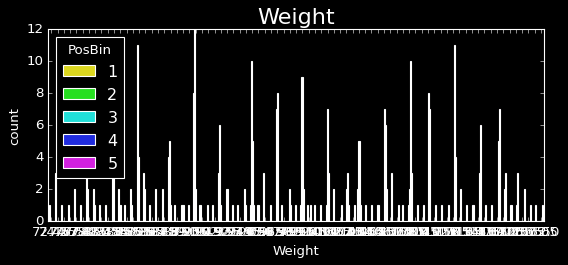

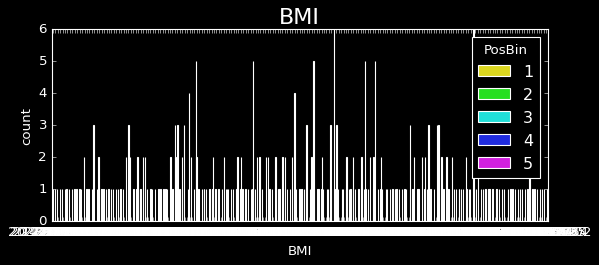

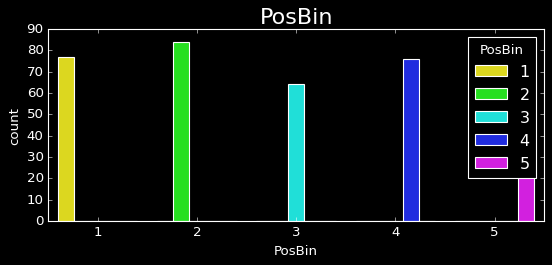

In [ ]:
for i in features:
    plt.figure(figsize=(8,3))
    plt.style.use(['seaborn-bright','dark_background'])
    sns.countplot(x = data[i],data = data, hue = 'PosBin', palette='hsv')
    plt.title(i,fontsize=20,color='w')

#### Observation: 

In [ ]:
x_onehot = OneHotEncoder().fit_transform(X)
x_onehot.shape

(350, 4686)

### Division en train/test set.

(avec sklearn)

In [ ]:
from sklearn.model_selection import train_test_split

## on prend 80% pour le train+validation set, 20% pour le test (tout a la fin !)
x_train, x_test, y_train, y_test = train_test_split(x_onehot.toarray(), y, test_size=0.2, random_state = 101)

## on prend 20% du 80% pour le validation set
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2, random_state = 101)

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((224, 4686), (56, 4686), (224,), (56,))

# Perceptron :


No convergence after 200 iterations.
There were misClassifiedNumber*100/N= 44.48979591836735 % misclassified data points.


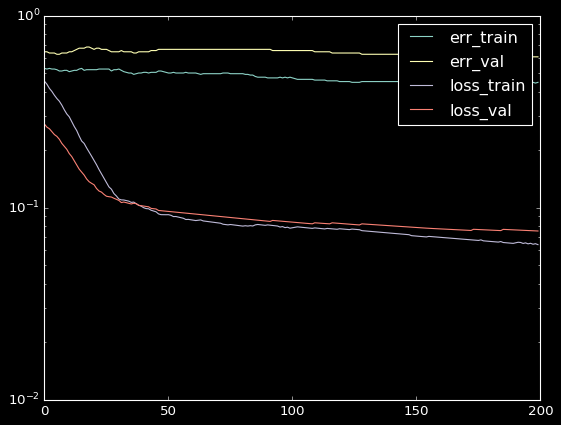

In [ ]:
### hyper-parameters ###
MAXITER=200
eta = 0.001

## on lance le calcul
plotting=False
verbose=False

## on initialise w avec la bonne dimension (ceci pourrait/devrait etre fait dans la fonction de fit, en fait)
np.random.seed(1)
w0 = initializeWeights(X, "random")

w, err_train, err_val, loss_train, loss_val =  perceptronFullBatch_version_decoree(X,y,eta, w0, MAXITER, plotting, verbose)

plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')
plt.plot(loss_train, label = 'loss_train')
plt.plot(loss_val, label = 'loss_val')
plt.semilogy()
plt.legend()

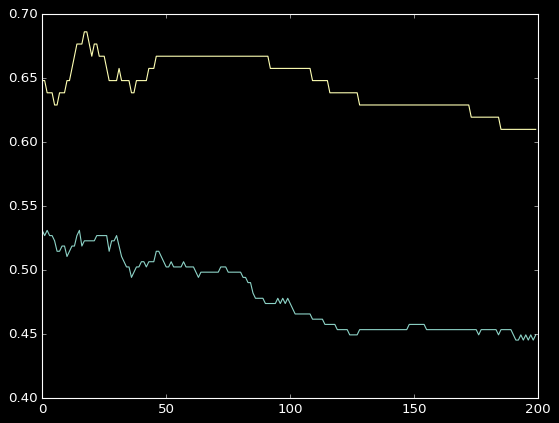

In [ ]:
plt.plot(err_train, label = 'err_train')
plt.plot(err_val, label = 'err_val')

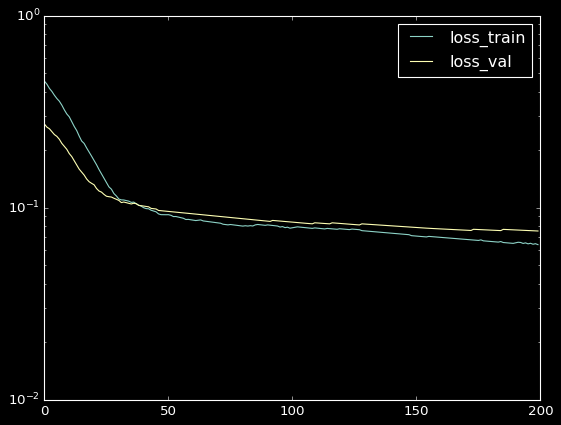

In [ ]:
plt.plot(loss_train, label = 'loss_train')
plt.plot(loss_val, label = 'loss_val')
plt.semilogy()
plt.legend()